<a href="https://colab.research.google.com/github/rareshnz/Licenta_Ciuperci/blob/main/model_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from tensorflow.keras.applications import xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np

X_train = []
y_train = []

dataset_path = '/content/drive/MyDrive/Mushrooms2'  
categories = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Lactarius', 'Russula']  


for idx, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (299, 299))  
        img = xception.preprocess_input(img)  
        X_train.append(img)
        y_train.append(idx)

X_train = np.array(X_train)
y_train = np.array(y_train)


y_train = to_categorical(y_train)


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)



In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os

base_model = Xception(weights='imagenet', include_top=False) 


x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dense(512, activation='relu')(x)


predictions = Dense(len(categories), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

Epoch 1/30
160/160 [==============================] - 11s 53ms/step - loss: 0.8893 - accuracy: 0.6678 - val_loss: 0.8329 - val_accuracy: 0.6951
Epoch 2/30
160/160 [==============================] - 7s 42ms/step - loss: 0.6084 - accuracy: 0.7836 - val_loss: 0.6825 - val_accuracy: 0.7600
Epoch 3/30
160/160 [==============================] - 7s 42ms/step - loss: 0.4864 - accuracy: 0.8224 - val_loss: 0.6633 - val_accuracy: 0.7701
Epoch 4/30
160/160 [==============================] - 7s 42ms/step - loss: 0.4257 - accuracy: 0.8464 - val_loss: 0.6326 - val_accuracy: 0.7764
Epoch 5/30
160/160 [==============================] - 7s 42ms/step - loss: 0.3724 - accuracy: 0.8633 - val_loss: 0.6342 - val_accuracy: 0.7873
Epoch 6/30
160/160 [==============================] - 7s 42ms/step - loss: 0.3273 - accuracy: 0.8807 - val_loss: 0.6380 - val_accuracy: 0.7787
Epoch 7/30
160/160 [==============================] - 7s 42ms/step - loss: 0.2776 - accuracy: 0.9014 - val_loss: 0.6567 - val_accuracy: 0.774

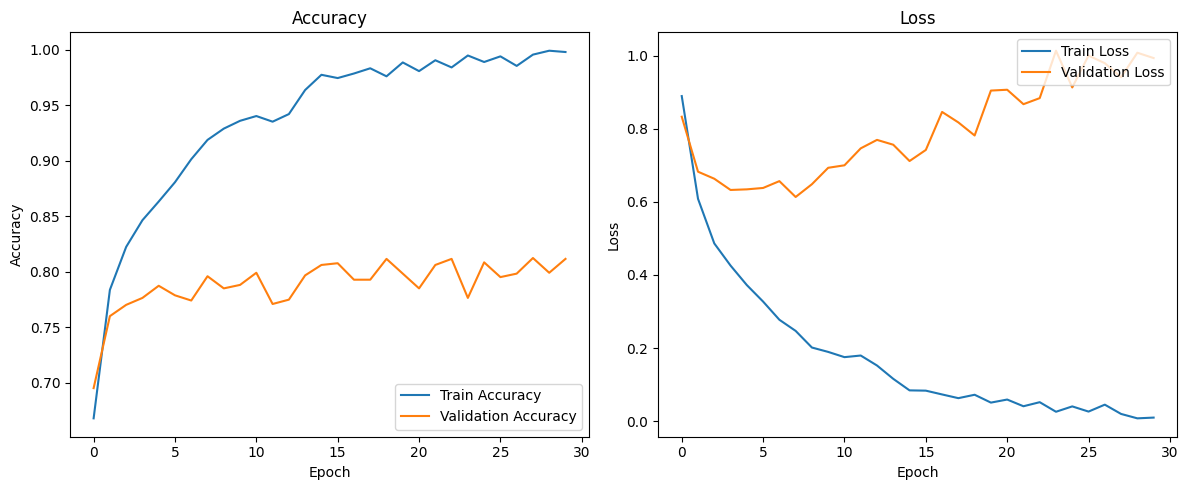

In [34]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    # Plot loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

40/40 [==============================] - 1s 30ms/step


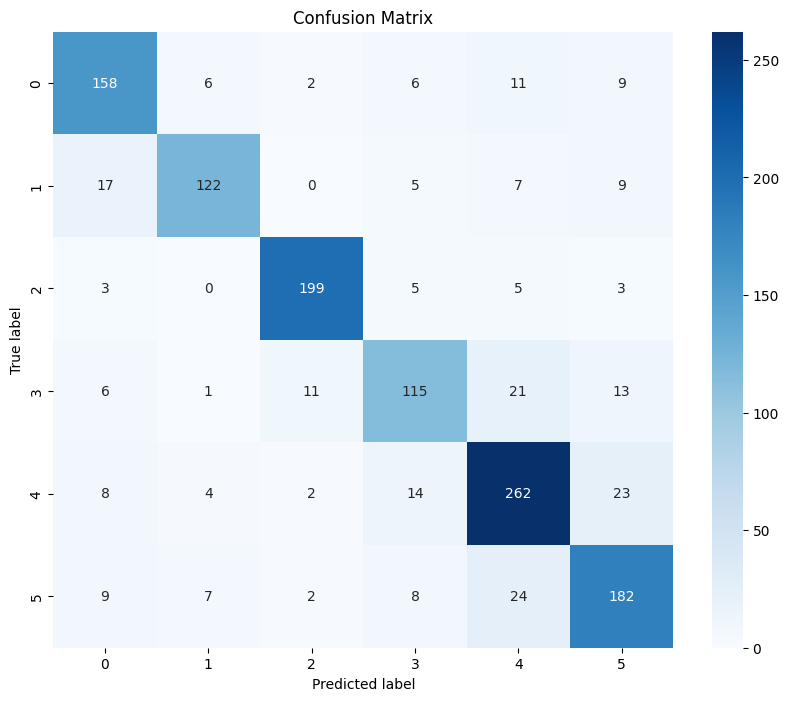

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_val, axis=1) 

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

40/40 [==============================] - 1s 30ms/step


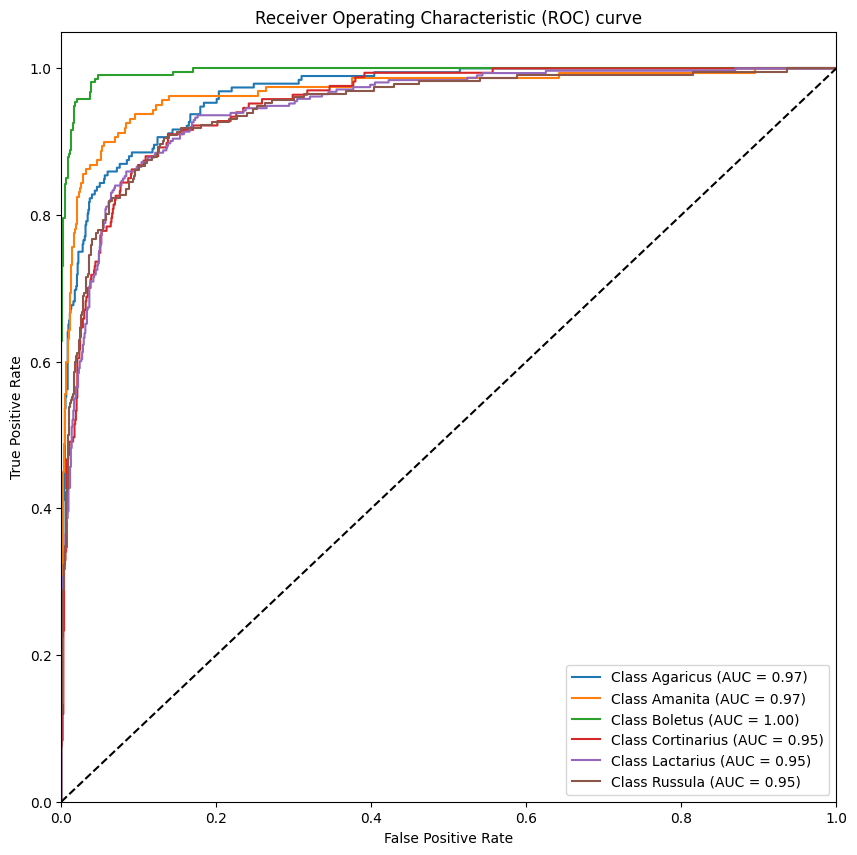

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_roc_and_auc(model, X_val, y_val, categories):
    n_classes = len(categories)
    
    y_val_binarized = label_binarize(y_val, classes=np.arange(n_classes))
    y_pred = model.predict(X_val)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_pred[:, i])
        roc_auc[i] = roc_auc_score(y_val_binarized[:, i], y_pred[:, i])

    # Plot ROC curve
    plt.figure(figsize=(10, 10))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {categories[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_and_auc(model, X_val, y_val, categories)

In [39]:
from sklearn.metrics import classification_report

def print_classification_report(model, X, y_true, categories):
    # Predict probabilities
    y_pred_prob = model.predict(X)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Convert one-hot encoded true labels to class labels
    y_true = np.argmax(y_true, axis=1)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=categories)
    
    print(report)

print_classification_report(model, X_val, y_val, categories)

40/40 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

    Agaricus       0.79      0.82      0.80       192
     Amanita       0.87      0.76      0.81       160
     Boletus       0.92      0.93      0.92       215
 Cortinarius       0.75      0.69      0.72       167
   Lactarius       0.79      0.84      0.81       313
     Russula       0.76      0.78      0.77       232

    accuracy                           0.81      1279
   macro avg       0.81      0.80      0.81      1279
weighted avg       0.81      0.81      0.81      1279



In [41]:
from sklearn.metrics import cohen_kappa_score

# Convert one-hot encoded labels to class labels
y_true = np.argmax(y_val, axis=1)

y_pred = np.argmax(model.predict(X_val), axis=1)
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa:", kappa)

40/40 [==============================] - 1s 30ms/step
Cohen's Kappa: 0.7706759813111924


In [42]:

X_test = []
y_test = []

test_dataset_path = '/content/drive/MyDrive/Test_Images2'  
categories = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Lactarius', 'Russula']  

for idx, category in enumerate(categories):
    category_path = os.path.join(test_dataset_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (299, 299))  
        img = xception.preprocess_input(img)  
        X_test.append(img)
        y_test.append(idx)

X_test = np.array(X_test)
y_test = np.array(y_test)


predictions = model.predict(X_test)


predicted_classes = np.argmax(predictions, axis=1)


print("Predicted class indices:", predicted_classes)


predicted_labels = [categories[idx] for idx in predicted_classes]
print("Predicted class labels:", predicted_labels)


3/3 [==============================] - 0s 34ms/step
Predicted class indices: [0 0 0 0 0 0 0 0 0 0 0 4 2 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 5 2 3 3 2 3 3 3 3 3 3 2 4 4 2 1 4 4 4 4 4 5 4 4 4 4 4 4 4
 4 4 4 4 5 5 4 0 0 5 5 5 5 1 4 4 5 5 4 5]
Predicted class labels: ['Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Lactarius', 'Boletus', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Lactarius', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Agaricus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Russula', 'Boletus', 'Cortinarius', 'Cortinarius', 'Boletus', 'Cortinarius', 'Cortinarius', 'Cortinarius', 'Cortinarius', 'Cortinarius', 'Cortinarius', 'Boletus', 'Lactarius', 'Lactarius', 'Bole

In [43]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(y_test, predicted_classes)

print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.776595744680851


In [ ]:

base_model.trainable = True


model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])


model.summary()

In [45]:
history_fine = model.fit(X_train, y_train, 
                                  epochs=10,
                                  validation_data=(X_val, y_val))


Epoch 1/10
160/160 [==============================] - 50s 142ms/step - loss: 2.9092 - accuracy: 0.6804 - val_loss: 1.5666 - val_accuracy: 0.7631
Epoch 2/10
160/160 [==============================] - 20s 128ms/step - loss: 0.7306 - accuracy: 0.8490 - val_loss: 1.4869 - val_accuracy: 0.7709
Epoch 3/10
160/160 [==============================] - 20s 128ms/step - loss: 0.3400 - accuracy: 0.9024 - val_loss: 1.3702 - val_accuracy: 0.7780
Epoch 4/10
160/160 [==============================] - 20s 127ms/step - loss: 0.1743 - accuracy: 0.9415 - val_loss: 1.2690 - val_accuracy: 0.7834
Epoch 5/10
160/160 [==============================] - 20s 128ms/step - loss: 0.1084 - accuracy: 0.9640 - val_loss: 1.2245 - val_accuracy: 0.7873
Epoch 6/10
160/160 [==============================] - 20s 128ms/step - loss: 0.0913 - accuracy: 0.9673 - val_loss: 1.2036 - val_accuracy: 0.7944
Epoch 7/10
160/160 [==============================] - 20s 128ms/step - loss: 0.0593 - accuracy: 0.9785 - val_loss: 1.1778 - val_ac

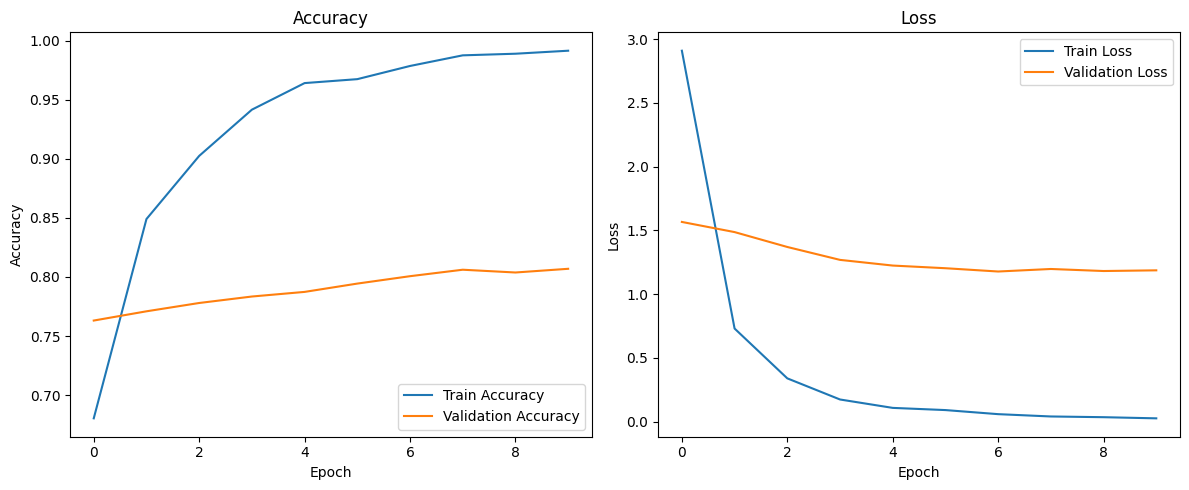

In [46]:
plot_training_history(history_fine)

40/40 [==============================] - 1s 30ms/step


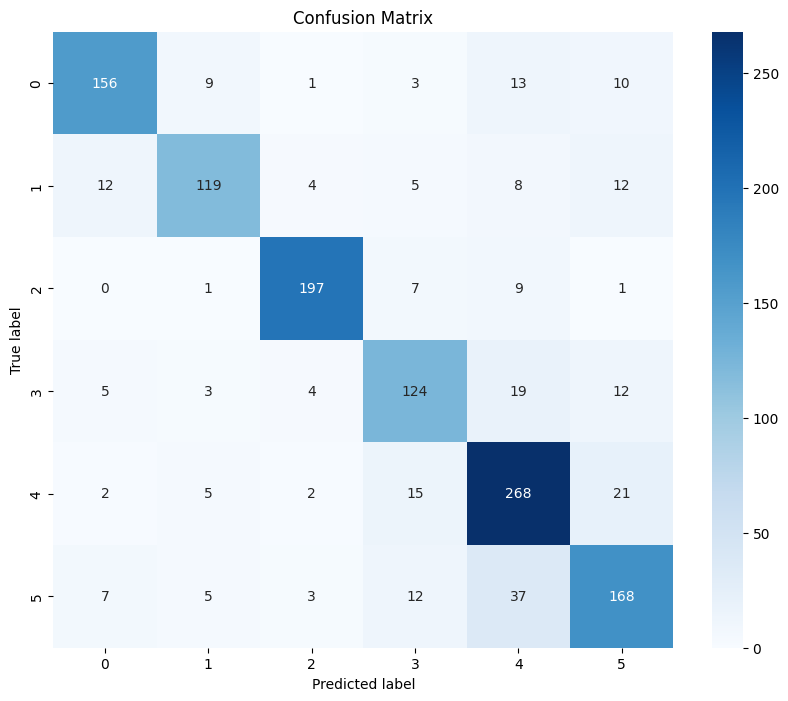

In [48]:

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_val, axis=1) 

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

40/40 [==============================] - 1s 31ms/step


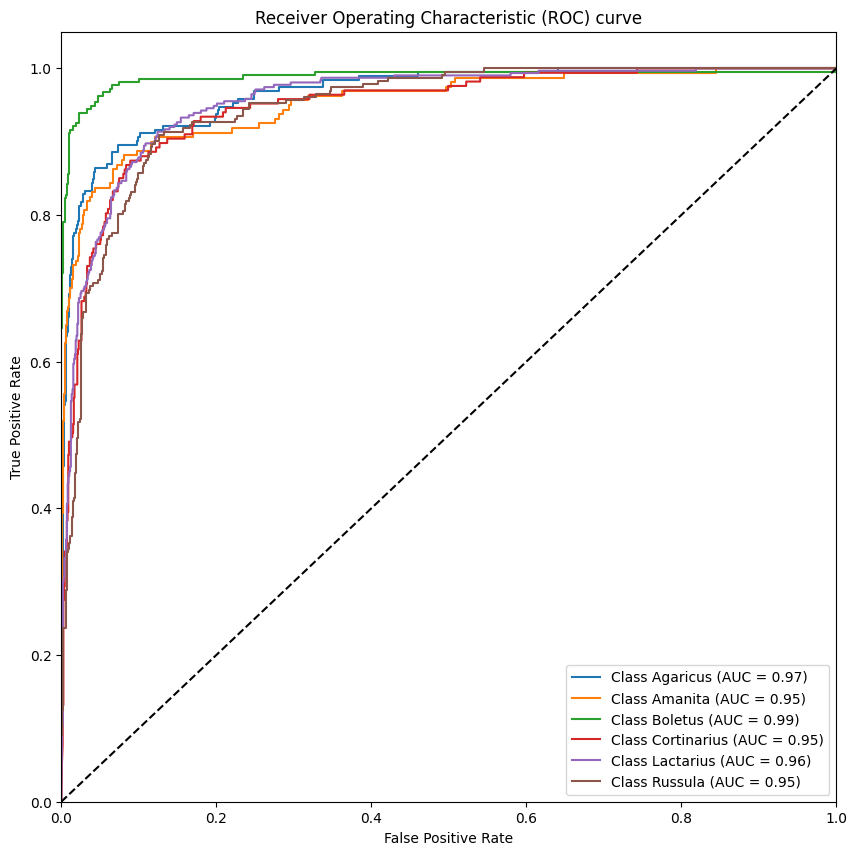

In [49]:
plot_roc_and_auc(model, X_val, y_val, categories)

In [50]:
print_classification_report(model, X_val, y_val, categories)

40/40 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

    Agaricus       0.86      0.81      0.83       192
     Amanita       0.84      0.74      0.79       160
     Boletus       0.93      0.92      0.92       215
 Cortinarius       0.75      0.74      0.74       167
   Lactarius       0.76      0.86      0.80       313
     Russula       0.75      0.72      0.74       232

    accuracy                           0.81      1279
   macro avg       0.81      0.80      0.81      1279
weighted avg       0.81      0.81      0.81      1279



In [51]:
# Convert one-hot encoded labels to class labels
y_true = np.argmax(y_val, axis=1)

y_pred = np.argmax(model.predict(X_val), axis=1)
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa:", kappa)

40/40 [==============================] - 1s 30ms/step
Cohen's Kappa: 0.7646514988974313


In [52]:
predictions = model.predict(X_test)

# Get the indices of the maximum values along an axis
predicted_classes = np.argmax(predictions, axis=1)

# Print the predicted class indices
print("Predicted class indices:", predicted_classes)

# If you want to map these class indices back to their respective class labels
predicted_labels = [categories[idx] for idx in predicted_classes]
print("Predicted class labels:", predicted_labels)

3/3 [==============================] - 0s 33ms/step
Predicted class indices: [0 0 3 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 3 3 4 2 3 3 3 3 3 3 2 3 3 2 1 4 4 4 0 4 3 4 4 4 4 4 4 4
 0 4 3 4 5 5 4 5 1 5 5 5 4 5 5 4 5 5 4 5]
Predicted class labels: ['Agaricus', 'Agaricus', 'Cortinarius', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Agaricus', 'Amanita', 'Amanita', 'Amanita', 'Agaricus', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Amanita', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Agaricus', 'Cortinarius', 'Cortinarius', 'Lactarius', 'Boletus', 'Cortinarius', 'Cortinarius', 'Cortinarius', 'Cortinarius', 'Cortinarius', 'Cortinarius', 'Boletus', 'Cortinarius', 'Cortinarius

In [53]:
accuracy = accuracy_score(y_test, predicted_classes)

print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.8085106382978723


In [54]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input

image_paths = [
    '/content/drive/My Drive/poze_reale/1.jpg',
    '/content/drive/My Drive/poze_reale/2.jpg',
    '/content/drive/My Drive/poze_reale/3.jpg',
    '/content/drive/My Drive/poze_reale/4.jpg',
    '/content/drive/My Drive/poze_reale/5.jpg',
    '/content/drive/My Drive/poze_reale/6.jpg',
    '/content/drive/My Drive/poze_reale/7.jpg',
    '/content/drive/My Drive/poze_reale/8.jpg',
    '/content/drive/My Drive/poze_reale/9.jpg',
    '/content/drive/My Drive/poze_reale/10.jpg',
    '/content/drive/My Drive/poze_reale/11.jpg'
]

for image_path in image_paths:
    # Load and prepare the image
    image = load_img(image_path, target_size=(299, 299))  
    image = img_to_array(image)  
    image = preprocess_input(image) 
    image = np.expand_dims(image, axis=0)  

    
    pred = model.predict(image)
    class_index = np.argmax(pred)  # Get the index of the class with the highest probability

    print("Predicted class index for image", image_path, ":", class_index)
    print("Predicted probabilities:", pred)

1/1 [==============================] - 0s 156ms/step
Predicted class index for image /content/drive/My Drive/poze_reale/1.jpg : 0
Predicted probabilities: [[9.9988043e-01 1.0636303e-04 1.6699774e-08 3.3848174e-11 1.3168353e-05
  4.1980326e-09]]
1/1 [==============================] - 0s 23ms/step
Predicted class index for image /content/drive/My Drive/poze_reale/2.jpg : 0
Predicted probabilities: [[9.9999201e-01 6.2997697e-07 2.2609443e-18 1.8853778e-15 1.5864042e-10
  7.4432205e-06]]
1/1 [==============================] - 0s 24ms/step
Predicted class index for image /content/drive/My Drive/poze_reale/3.jpg : 4
Predicted probabilities: [[1.3586209e-04 1.9586184e-10 8.2738554e-09 1.1416685e-09 9.1146553e-01
  8.8398732e-02]]
1/1 [==============================] - 0s 24ms/step
Predicted class index for image /content/drive/My Drive/poze_reale/4.jpg : 0
Predicted probabilities: [[9.7010660e-01 2.3329382e-11 1.9190805e-04 2.9678388e-02 3.1102019e-08
  2.3111374e-05]]
1/1 [==================